In [2]:
from sklearn.datasets import fetch_openml

# Download the dataset from openml
dataset = fetch_openml(data_id=42803, as_frame=True)

# Extract feature matrix X and show 5 random samples
df_X = dataset["frame"]

# Structure Investigation
let’s first look at the general structure of the dataset. For example, how many columns and rows does the dataset have?

In [3]:
# Show size of the dataset
df_X.shape

(363243, 67)

So we know that this dataset has 363’243 samples and 67 features. And how many different data types do these 67 features contain?

In [4]:
import pandas as pd

# Count how many times each data type is present in the dataset
pd.value_counts(df_X.dtypes)

float64    61
object      6
dtype: int64

## Structure of non-numerical features:
Data types can be numerical and non-numerical. First, let’s take a closer look at the non-numerical entries.

In [5]:
# Display non-numerical features
df_X.select_dtypes(exclude="number").head()

,Accident_Index,Sex_of_Driver,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
0,201501BS70001,1.0,12/01/2015,18:45,E09000020,E01002825
1,201501BS70002,1.0,12/01/2015,07:50,E09000020,E01002820
2,201501BS70004,1.0,12/01/2015,18:08,E09000020,E01002833
3,201501BS70005,1.0,13/01/2015,07:40,E09000020,E01002874
4,201501BS70008,1.0,09/01/2015,07:30,E09000020,E01002814


Even though `Sex_of_Driver` is a numerical feature, it somehow was stored as a non-numerical one. This is sometimes due to some typo in data recording. So let’s take care of that:

In [6]:
# Changes data type of 'Sex_of_Driver'
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")

Using the `.describe()` function we can also investigate how many unique values each non-numerical feature has and with which frequency the most prominent value is present.

In [7]:
df_X.describe(exclude="number")

,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,363243,319866,319822,319866,298758
unique,140056,365,1439,204,25979
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2972,8457,1456


## Structure of numerical features:
Next, let’s take a closer look at the numerical features. More precisely, let’s investigate how many unique values each of these feature has. This process will give us some insights about the number of binary (2 unique values), ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the dataset.

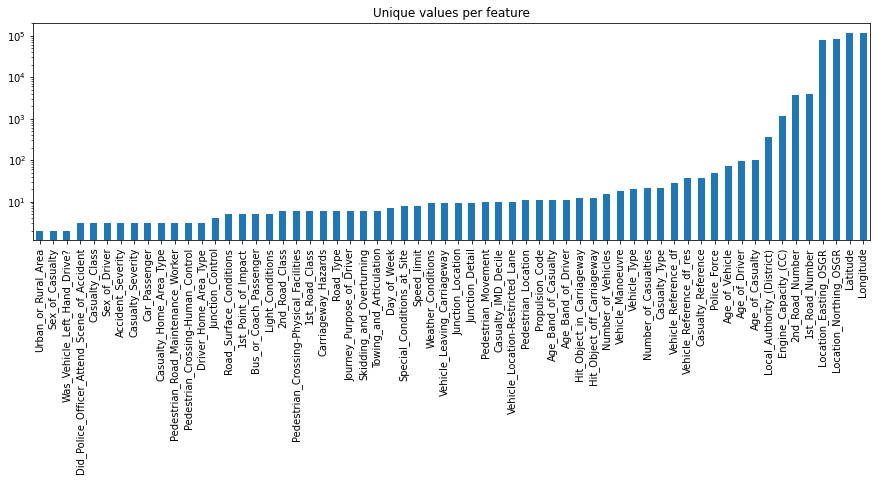

In [8]:
# For each numerical feature compute number of unique entries
unique_values = df_X.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

# Quality Investigation
Before focusing on the actual content stored in these features, let’s first take a look at the general quality of the dataset. The goal is to have a global view on the dataset with regards to things like duplicates, missing values and unwanted entries or recording errors.

## Duplicates:
Duplicates are entries that represent the same sample point multiple times. For example, if a measurement was registered twice by two different people. Detecting such duplicates is not always easy, as each dataset might have a unique identifier (e.g. an index number or recording time that is unique to each new sample) which you might want to ignore first.

In [9]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df_X.drop(labels=["Accident_Index"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 22 duplicates in your database.


To handle these duplicates you can just simply drop them with `.drop_duplicates()`.

In [10]:
# Extract column names of all features, except 'Accident_Index'
columns_to_consider = df_X.drop(labels=["Accident_Index"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
df_X = df_X.drop_duplicates(subset=columns_to_consider)
df_X.shape

(363221, 67)

## Missing values:
Another quality issue worth to investigate are missing values. Having some missing values is normal. What we want to identify at this stage are big holes in the dataset, i.e. samples or features with a lot of missing values.

### Per sample:
To look at number of missing values per sample we have multiple options. The most straight forward one is to simply visualize the output of `df_X.isna()`, with something like this:

Text(0, 0.5, 'Sample Number')

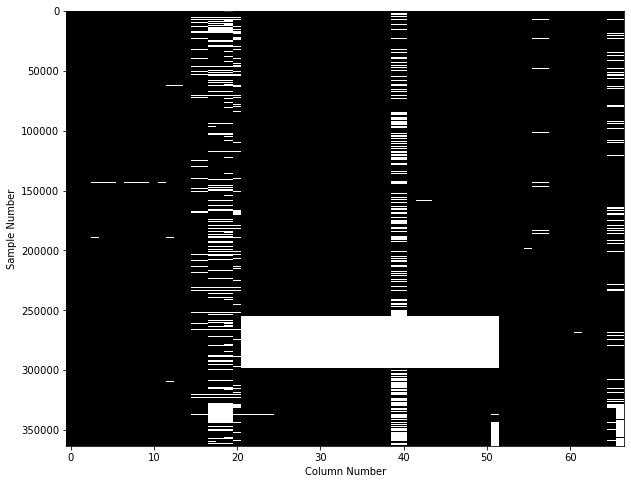

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_X.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

This figure shows on the y-axis each of the 360’000 individual samples, and on the x-axis if any of the 67 features contains a missing value. While this is already a useful plot, an even better approach is to use the missingno library, to get a plot like this one:

<AxesSubplot:>

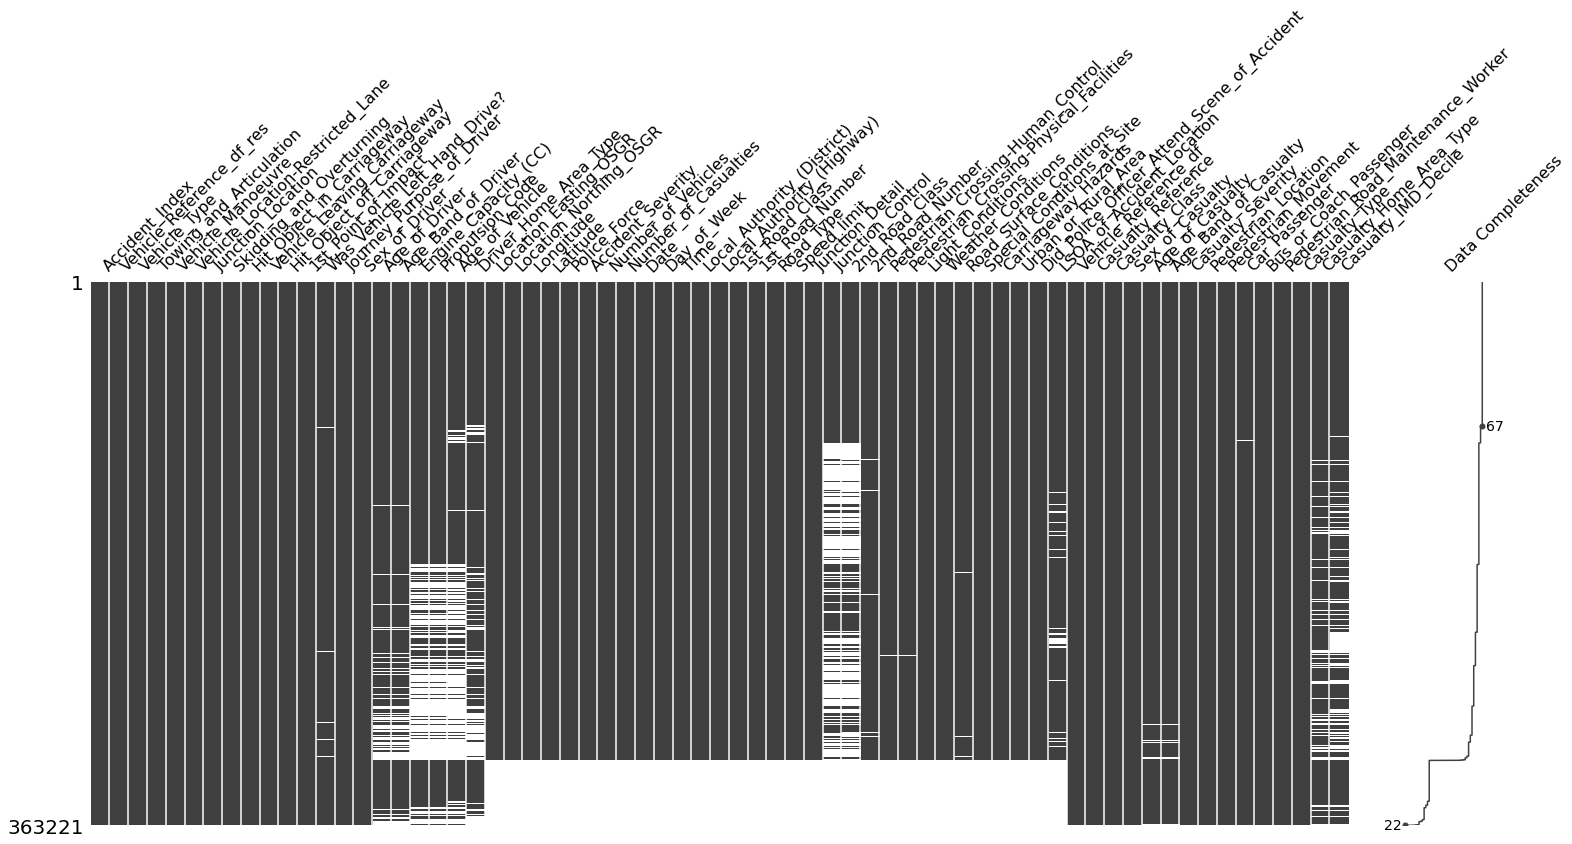

In [12]:
import missingno as msno

msno.matrix(df_X, labels=True, sort="descending")

From both of these plots we can see that the dataset has a huge whole, caused by some samples where more than 50% of the feature values are missing. For those samples, filling the missing values with some replacement values is probably not a good idea.

Therefore, let’s go ahead and drop samples that have more than 20% of missing values. The threshold is inspired by the information from the ‘Data Completeness’ column on the right of this figure.

In [13]:
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.80, axis=0).reset_index(drop=True)
df_X.shape

(319790, 67)

## Per Feature:

As a next step, let’s now look at the number of missing values per feature. For this we can use some pandas trickery to quickly identify the ratio of missing values per feature.

<AxesSubplot:title={'center':'Percentage of missing values per feature'}, ylabel='Ratio of missing values per feature'>

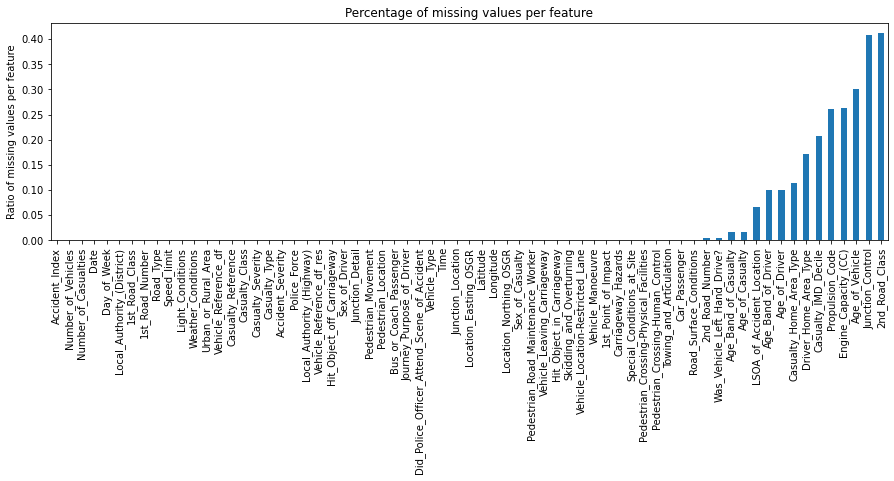

In [14]:
df_X.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature", 
    ylabel="Ratio of missing values per feature")

From this figure we can see that most features don’t contain any missing values. Nonetheless, features like 2nd_Road_Class, Junction_Control, Age_of_Vehicle still contain quite a lot of missing values. So let’s go ahead and remove any feature with more than 15% of missing values.

In [15]:
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)
df_X.shape

(319790, 60)

## Small side note:

Missing values: There is no strict order in removing missing values. For some datasets, tackling first the features and than the samples might be better. Furthermore, the threshold at which you decide to drop missing values per feature or sample changes from dataset to dataset, and depends on what you intend to do with the dataset later on.

Also, until now we only addressed the big holes in the dataset, not yet how we would fill the smaller gaps. This is content for another post.

## Unwanted entries and recording errors

Another source of quality issues in a dataset can be due to unwanted entries or recording errors. It’s important to distinguish such samples from simple outliers. While outliers are data points that are unusual for a given feature distribution, unwanted entries or recording errors are samples that shouldn’t be there in the first place.

For example, a temperature recording of 45°C in Switzerland might be an outlier (as in ‘very unusual’), while a recording at 90°C would be an error. Similarly, a temperature recording from the top of Mont Blanc might be physical possible, but most likely shouldn’t be included in a dataset about Swiss cities.

Of course, detecting such errors and unwanted entries and distinguishing them from outliers is not always straight forward and depends highly on the dataset. One approach to this is to take a global view on the dataset and see if you can identify some very unusual patterns.

## Numerical features
To plot this global view of the dataset, at least for the numerical features, you can use pandas’ .plot() function and combine it with the following parameters:

* `lw=0: lw` stands for line width. 0 means that we don’t want to show any lines
* `marker="."`: Instead of lines, we tell the plot to use . as markers for each data point
* `subplots=True`: `subplots` tells pandas to plot each feature in a separate subplot
* `layout=(-1, 4)`: This parameter tells pandas how many rows and columns to use for the subplots. The -1 means “as many as needed”, while the 2 means to use 2 columns per row.
* `figsize=(15, 30)`, `markersize=1`: To make sure that the figure is big enough we recommend to have a figure height of roughly the number of features, and to adjust the `markersize` accordingly.

So what does this plot look like?

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplo

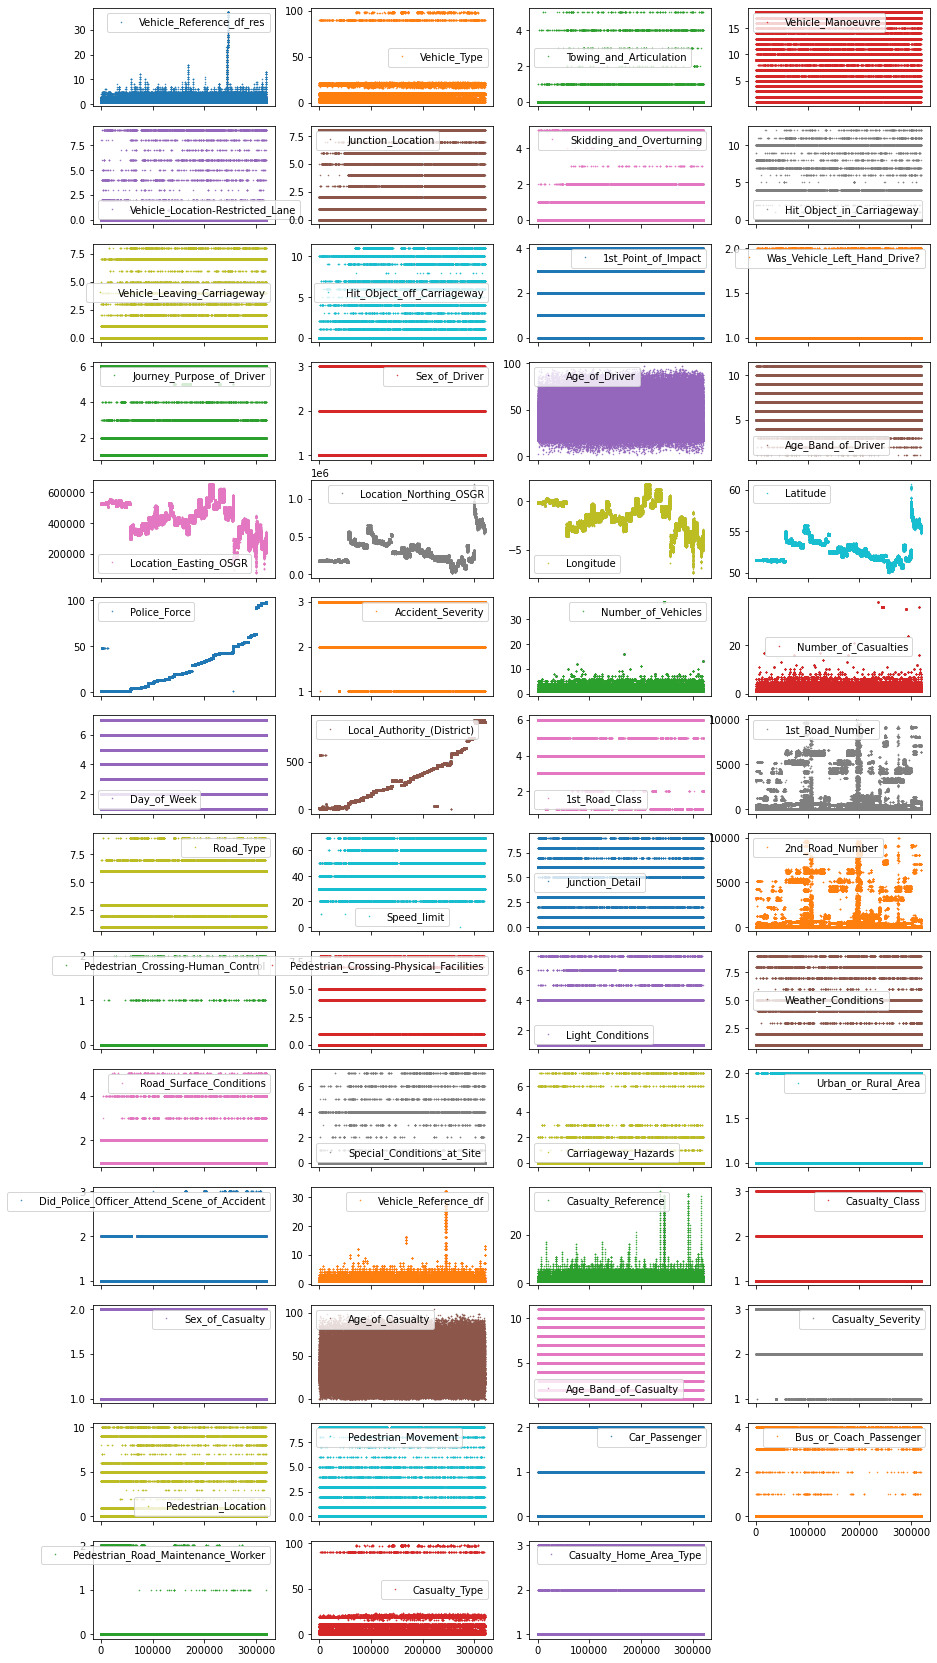

In [16]:
df_X.plot(lw=0, marker=".", subplots=True, layout=(-1, 4), figsize=(15, 30), markersize=1)

Each point in this figure is a sample (i.e. a row) in our dataset and each subplot represents a different feature. The y-axis shows the feature value, while the x-axis is the sample index. These kind of plots can give you a lot of ideas for data cleaning and EDA. Usually it makes sense to invest as much time as needed until your happy with the output of this visualization.

## Non-numerical features:
Identifying unwanted entries or recording errors on non-numerical features is a bit more tricky. Given that at this point, we only want to investigate the general quality of the dataset. So what we can do is take a general look at how many unique values each of these non-numerical features contain, and how often their most frequent category is represented.

In [17]:
# Extract descriptive properties of non-numerical features
df_X.describe(exclude=["number", "datetime"])

,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,319790,319790,319746,319790,298693
unique,123645,365,1439,204,25977
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2969,8457,1456


There are multiple ways for how you could potentially streamline the quality investigation for each individual non-numerical features. None of them is perfect, and all of them will require some follow up investigation. But for the purpose of showcasing one such a solution, what we could do is loop through all non-numerical features and plot for each of them the number of occurrences per unique value.

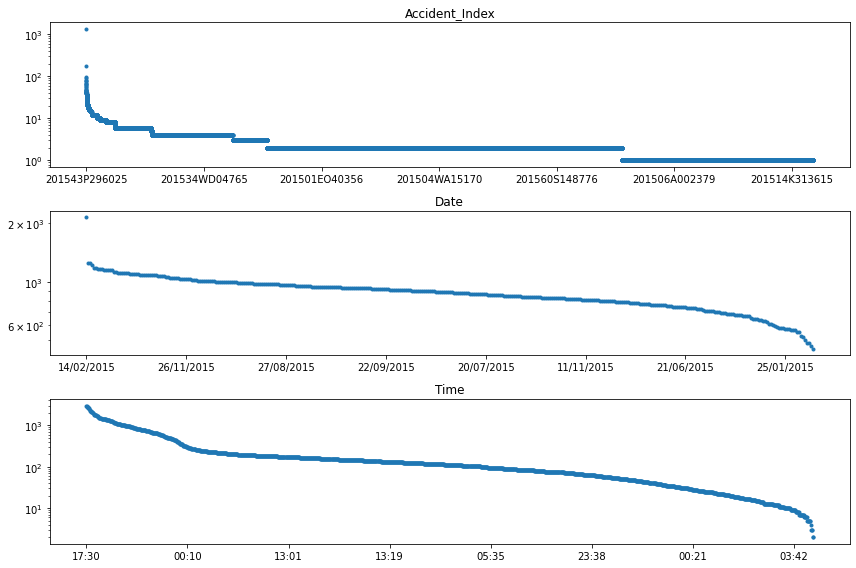

In [18]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))

# Identify non-numerical features
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout()

We can see that the most frequent accident (i.e. Accident_Index), had more than 100 people involved. Digging a bit deeper (i.e. looking at the individual features of this accident), we could identify that this accident happened on February 24th, 2015 at 11:55 in Cardiff UK. A quick internet search reveals that this entry corresponds to a luckily non-lethal accident including a minibus full of pensioners.

The decision for what should be done with such rather unique entries is once more left in the the subjective hands of the person analyzing the dataset. Without any good justification for WHY, and only with the intention to show you the HOW - let’s go ahead and remove the 10 most frequent accidents from this dataset.

In [19]:
# Collect entry values of the 10 most frequent accidents
accident_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index

# Removes accidents from the 'accident_ids' list
df_X = df_X[~df_X["Accident_Index"].isin(accident_ids)]
df_X.shape

(317665, 60)

## Conclusion of quality investigation:
At the end of this second investigation, we should have a better understanding of the general quality of our dataset. We looked at duplicates, missing values and unwanted entries or recording errors. It is important to point out that we didn’t discuss yet how to address the remaining missing values or outliers in the dataset. This is a task for the next investigation, but won’t be covered in this article.

# Content Investigation
Up until now we only looked at the general structure and quality of the dataset. Let’s now go a step further and take a look at the actual content. In an ideal setting, such an investigation would be done feature by feature. But this becomes very cumbersome once you have more than 20-30 features.

For this reason (and to keep this article as short as needed) we will explore three different approaches that can give you a very quick overview of the content stored in each feature and how they relate.

## Feature distribution:
Looking at the value distribution of each feature is a great way to better understand the content of your data. Furthermore, it can help to guide your EDA, and provides a lot of useful information with regards to data cleaning and feature transformation. The quickest way to do this for numerical features is using histogram plots. Luckily, pandas comes with a builtin histogram function that allows the plotting of multiple features at once.

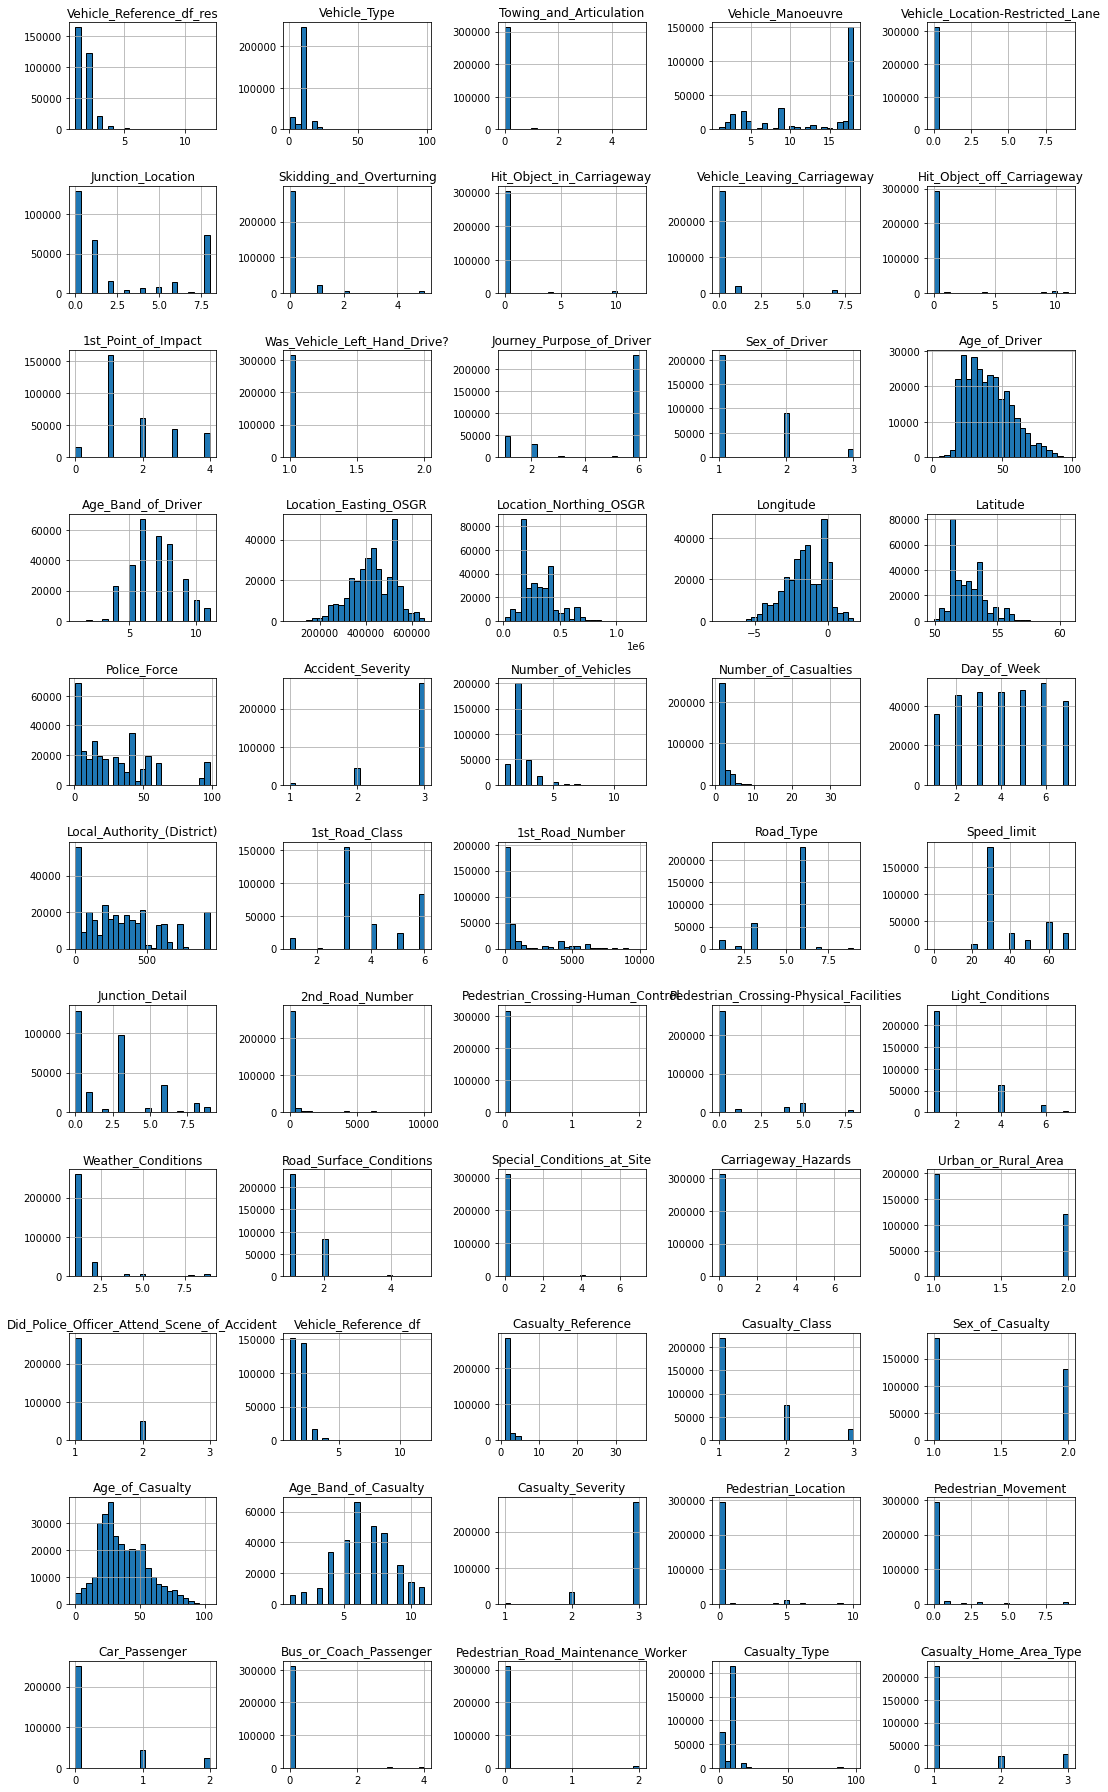

In [20]:
# Plots the histogram for each numerical feature in a separate subplot
df_X.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

There are a lot of very interesting things visible in this plot. For example…

Most frequent entry: Some features, such as `Towing_and_Articulation` or `Was_Vehicle_Left_Hand_Drive`? mostly contain entries of just one category. Using the `.mode()` function, we could for example extract the ratio of the most frequent entry for each feature and visualize that information.

Pedestrian_Crossing-Human_Control    0.995259
Was_Vehicle_Left_Hand_Drive?         0.990137
Carriageway_Hazards                  0.983646
Towing_and_Articulation              0.983221
Vehicle_Location-Restricted_Lane     0.982088
dtype: float64

<AxesSubplot:>

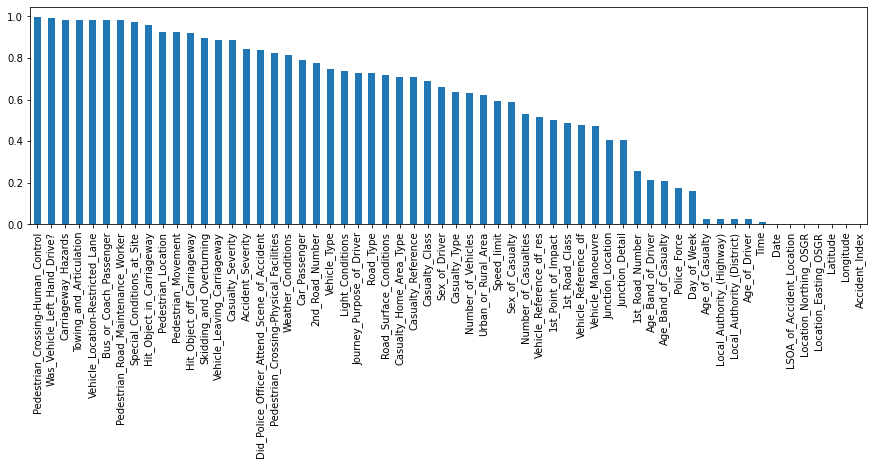

In [21]:
# Collects for each feature the most frequent entry
most_frequent_entry = df_X.mode()

# Checks for each entry if it contains the most frequent entry
df_freq = df_X.eq(most_frequent_entry.values, axis=1)

# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)

# Show the 5 top features with the highest ratio of singular value content
display(df_freq.head())

# Visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15, 4))

Skewed value distributions: Certain kind of numerical features can also show strongly non-gaussian distributions. In that case you might want to think about how you can transform these values to make them more normal distributed. For example, for right skewed data you could use a log-transformation.

## Feature patterns
Next step on the list is the investigation of feature specific patterns. The goal of this part is two fold:

1. Can we identify particular patterns within a feature that will help us to decide if some entries need to be dropped or modified?
2. Can we identify particular relationships between features that will help us to better understand our dataset?

But before we dive into these two questions, let’s take a closer look at a few ‘randomly selected’ features.

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

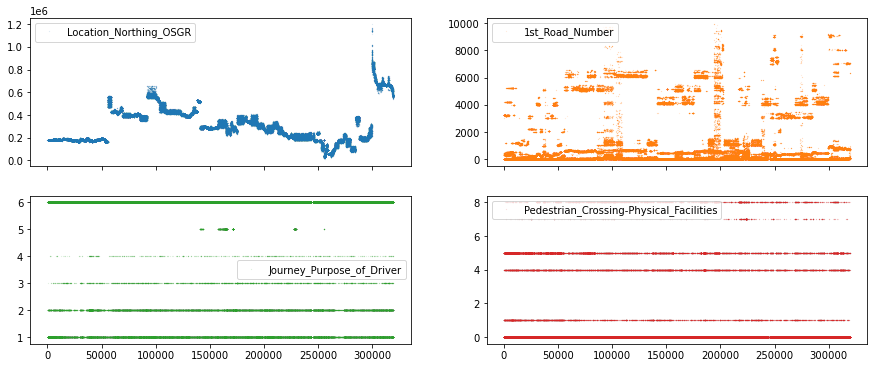

In [22]:
df_X[["Location_Northing_OSGR", "1st_Road_Number",
      "Journey_Purpose_of_Driver", "Pedestrian_Crossing-Physical_Facilities"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6))

In the top row, we can see features with continuous values (e.g. seemingly any number from the number line), while in the bottom row we have features with discrete values (e.g. 1, 2, 3 but not 2.34).

While there are many ways we could explore our features for particular patterns, let’s simplify our option by deciding that we treat features with less than 25 unique features as discrete or ordinal features, and the other features as continuous features.

In [23]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = df_X.select_dtypes(include="number").nunique() >= 25

## Continuous features
Now that we have a way to select the continuous features, let’s go ahead and use seaborn’s pairplot to visualize the relationships between these features. Important to note, seaborn’s pairplot routine can take a long time to create all subplots. Therefore we recommend to not use it for more than ~10 features at a time.

In [24]:
# Create a new dataframe which only contains the continuous features
df_continuous = df_X[cols_continuous[cols_continuous].index]
df_continuous.shape

(317665, 11)

Given that in our case we only have 11 features, we can go ahead with the pairplot. Otherwise, using something like `df_continuous.iloc[:, :5]` could help to reduce the number of features to plot.

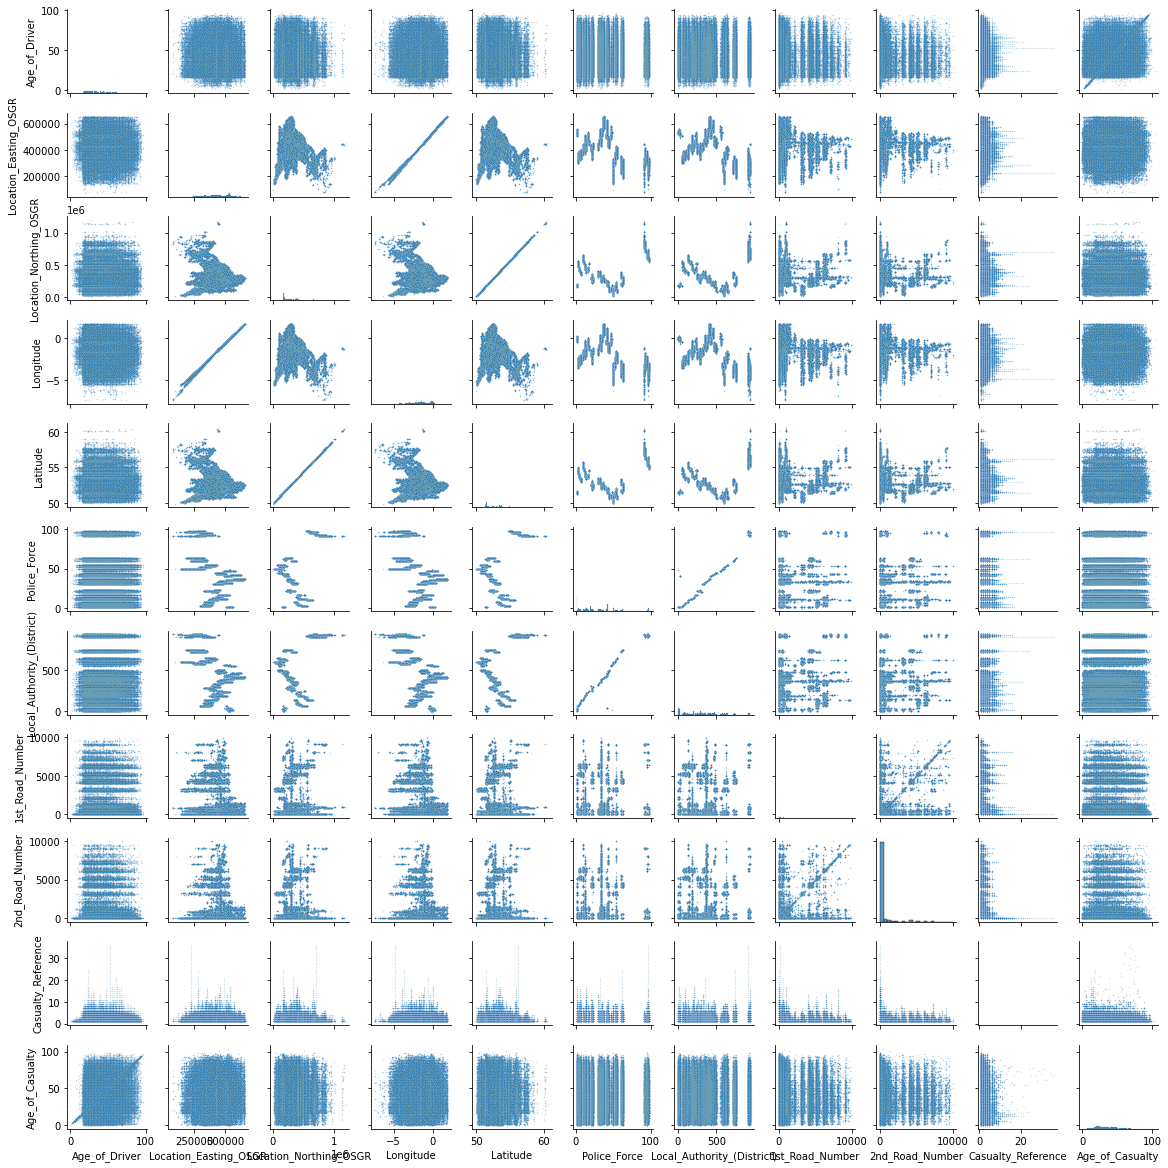

In [25]:
import seaborn as sns

sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2})

There seems to be a strange relationship between a few features in the top left corner. `Location_Easting_OSGR` and `Longitude`, as well as `Location_Easting_OSGR` and `Latitude` seem to have a very strong linear relationship.

In [ ]:
sns.pairplot(
    df_X, plot_kws={"s": 3, "alpha": 0.2}, hue="Police_Force", palette="Spectral",
    x_vars=["Location_Easting_OSGR", "Location_Northing_OSGR", "Longitude"],
    y_vars="Latitude");

Knowing that these features contain geographic information, a more in-depth EDA with regards to geolocation could be fruitful. However, for now we will leave the further investigation of this pairplot to the curious reader and continue with the exploration of the discrete and ordinal features.

## Discrete and ordinal features:
Finding patterns in the discrete or ordinal features is a bit more tricky. But also here, some quick pandas and seaborn trickery can help us to get a general overview of our dataset. First, let’s select the columns we want to investigate.

In [26]:
# Create a new dataframe which doesn't contain the numerical continuous features
df_discrete = df_X[cols_continuous[~cols_continuous].index]
df_discrete.shape

(317665, 44)

As always, there are multiple way for how we could investigate all of these features. Let’s try one example, using seaborn’s `stripplot()` together with a handy `zip()` for-loop for subplots.

**Note**, to spread the values out in the direction of the y-axis we need to chose one particular (hopefully informative) feature. While the ‘right’ feature can help to identify some interesting patterns, usually any continuous feature should do the trick. The main interest in this kind of plot is to see how many samples each discrete value contains.

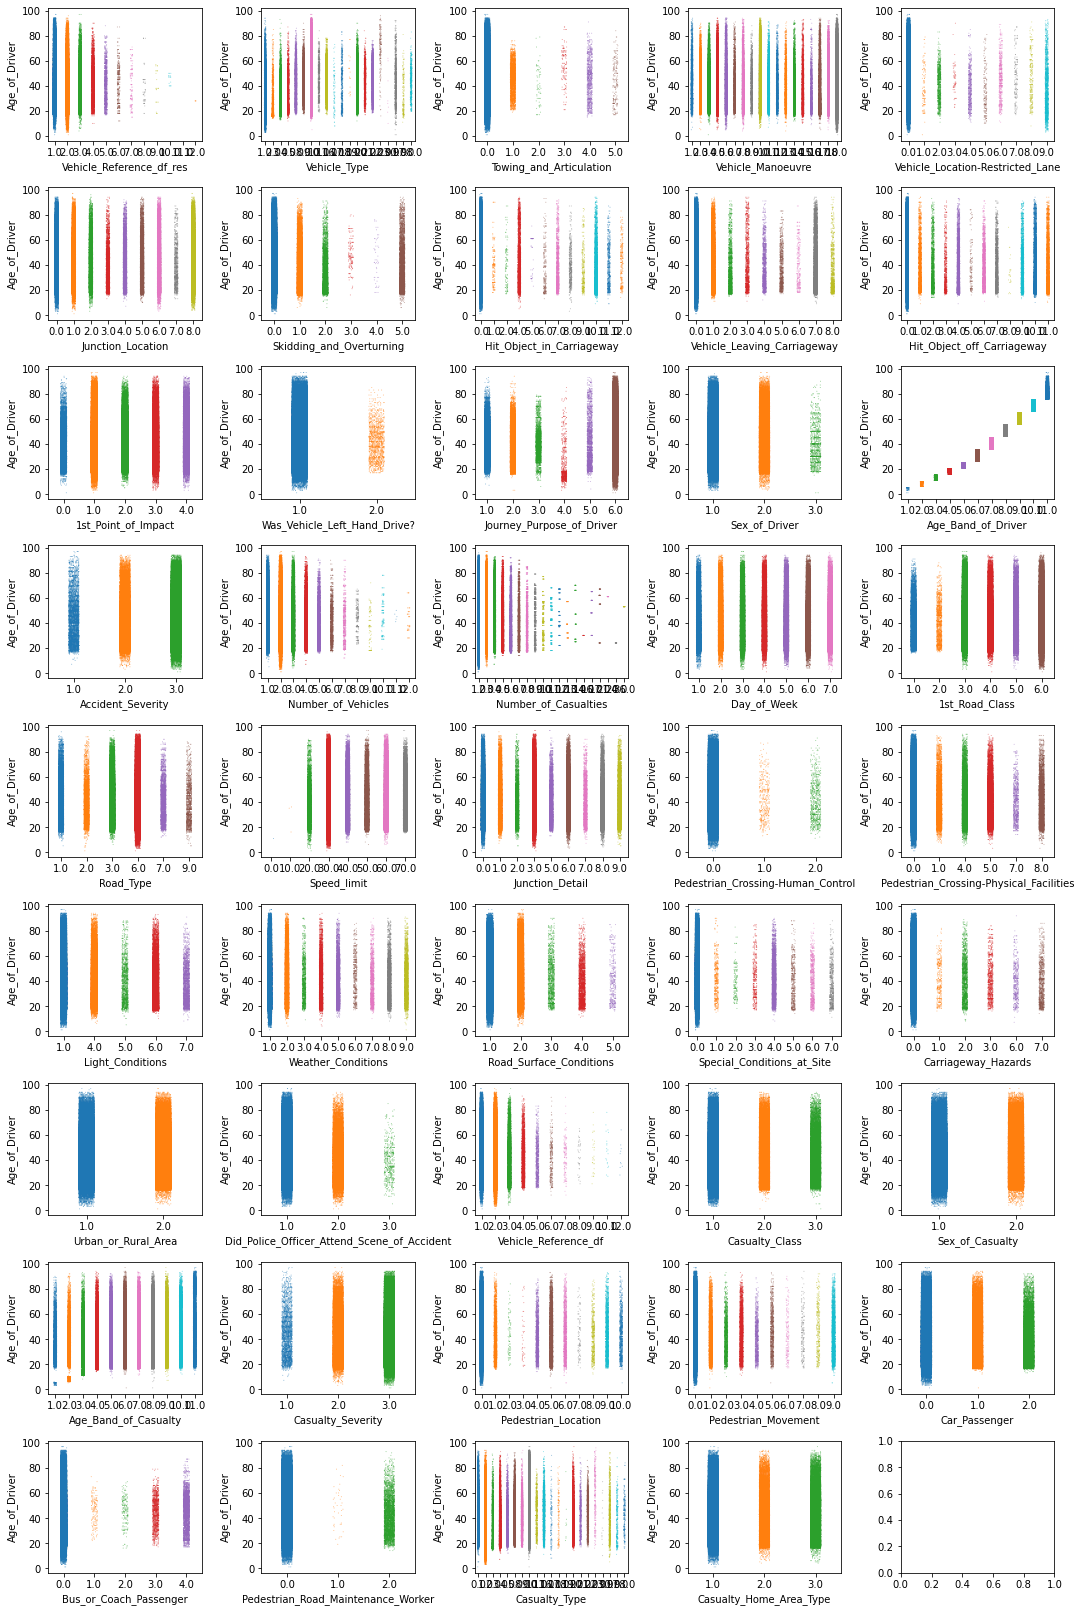

In [27]:
import numpy as np

# Establish number of columns and rows needed to plot all features
n_cols = 5
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")

# Specify y_value to spread data (ideally a continuous feature)
y_value = df_X["Age_of_Driver"]

# Create figure object with as many rows and columns as needed
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, n_rows * 2.5))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df_X, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
plt.tight_layout()

There are too many things to comment here, so let’s just focus on a few. In particular, let’s focus on 6 features where the values appear in some particular pattern or where some categories seem to be much less frequent than others. And to shake things up a bit, let’s now use the `Longitude` feature to stretch the values over the y-axis.

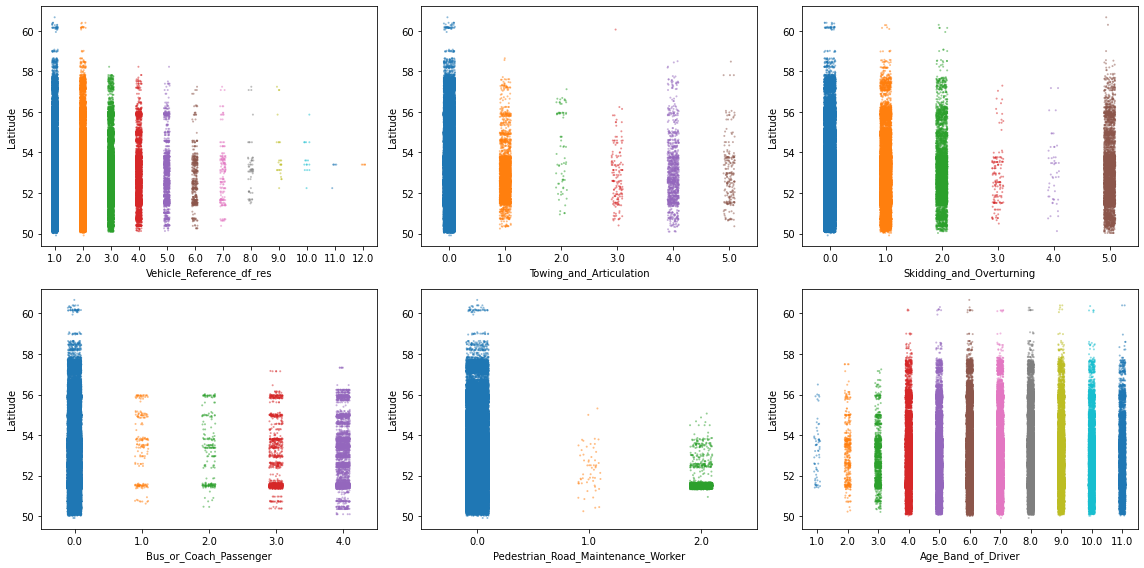

In [28]:
# Specify features of interest
selected_features = ["Vehicle_Reference_df_res", "Towing_and_Articulation",
                     "Skidding_and_Overturning", "Bus_or_Coach_Passenger",
                     "Pedestrian_Road_Maintenance_Worker", "Age_Band_of_Driver"]

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.stripplot(data=df_X, x=col, y=df_X["Latitude"], ax=ax,
                  palette="tab10", size=2, alpha=0.5)
plt.tight_layout()

These kind of plots are already very informative, but they obscure regions where there are a lot of data points at once. For example, there seems to be a high density of points in some of the plots at the 52nd latitude. So let’s take a closer look with an appropriate plot, such as `violineplot` ( or `boxenplot` or `boxplot` for that matter). And to go a step further, let’s also separate each visualization by `Urban_or_Rural_Area`.

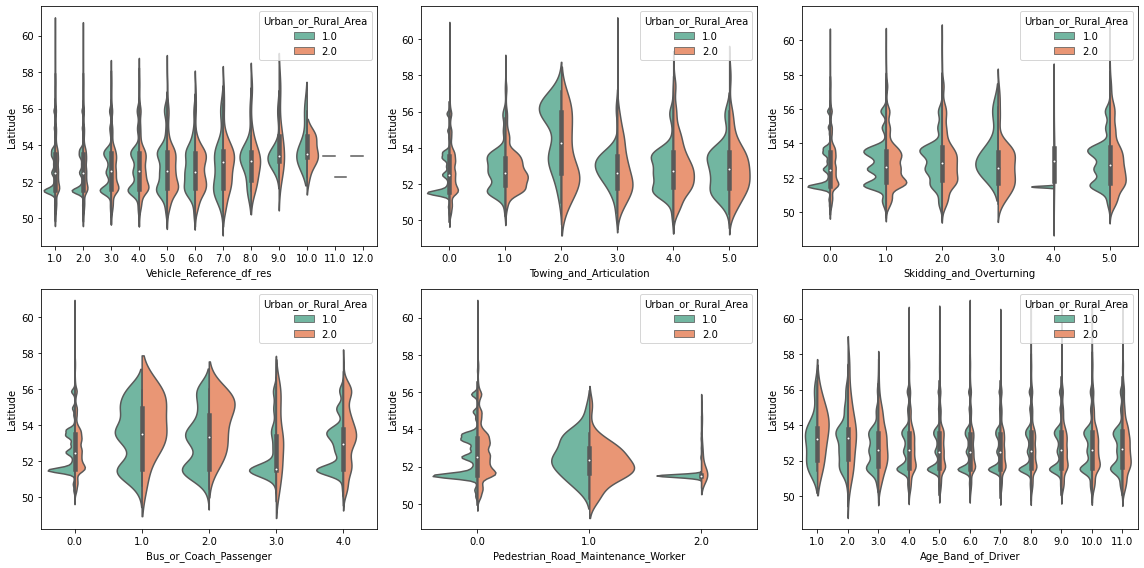

In [29]:
# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df_X, x=col, y=df_X["Latitude"], palette="Set2",
                   split=True, hue="Urban_or_Rural_Area", ax=ax)
plt.tight_layout()

Interesting! We can see that some values on features are more frequent in urban, than in rural areas (and vice versa). Furthermore, as suspected, there seems to be a high density peak at latitude 51.5. This is very likely due to the more densely populated region around London (at 51.5074°).

## Feature relationships:

Last, but not least, let’s take a look at relationships between features. More precisely how they correlate. The quickest way to do so is via pandas’ `.corr()` function. So let’s go ahead and compute the feature to feature correlation matrix for all numerical features.

In [30]:
# Computes feature correlation
df_corr = df_X.corr(method="pearson")

**Note**: Depending on the dataset and the kind of features (e.g. ordinal or continuous features) you might want to use the `spearman` method instead of the `pearson` method to compute the correlation. Whereas the Pearson correlation evaluates the linear relationship between two continuous variables, the Spearman correlation evaluates the monotonic relationship based on the ranked values for each feature. And to help with the interpretation of this correlation matrix, let’s use seaborn’s `.heatmap()` to visualize it.

<AxesSubplot:>

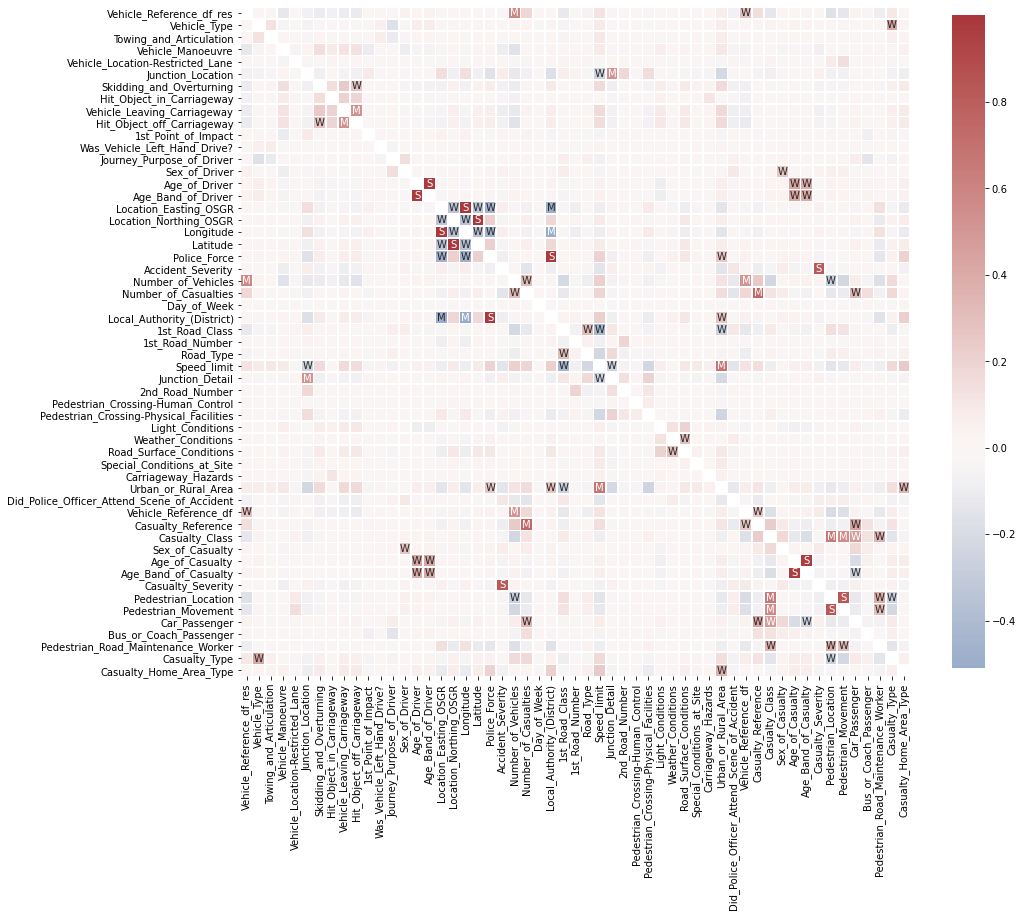

In [31]:
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M", np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5, cmap="vlag", cbar_kws={"shrink": 0.8})

This looks already very interesting. We can see a few very strong correlations between some of the features. Now, if you’re interested actually ordering all of these different correlations, you could do something like this:

In [32]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)

Local_Authority_(District)  Longitude                -0.509343
                            Location_Easting_OSGR    -0.502919
Police_Force                Longitude                -0.471327
                            Location_Easting_OSGR    -0.461112
Speed_limit                 1st_Road_Class           -0.438931
                                                        ...   
Age_Band_of_Casualty        Age_of_Casualty           0.974397
Age_Band_of_Driver          Age_of_Driver             0.979019
Local_Authority_(District)  Police_Force              0.984819
Longitude                   Location_Easting_OSGR     0.999363
Latitude                    Location_Northing_OSGR    0.999974
Length: 1485, dtype: float64

As you can see, the investigation of feature correlations can be very informative. But looking at everything at once can sometimes be more confusing than helpful. So focusing only on one feature with something like `df_X.corrwith(df_X["Speed_limit"])` might be a better approach.

Furthermore, correlations can be deceptive if a feature still contains a lot of missing values or extreme outliers. Therefore, it is always important to first make sure that your feature matrix is properly prepared before investigating these correlations.

# Conclusion of content investigation

At the end of this third investigation, we should have a better understanding of the content in our dataset. We looked at value distribution, feature patterns and feature correlations. However, these are certainly not all possible content investigation and data cleaning steps you could do. Additional steps would for example be outlier detection and removal, feature engineering and transformation, and more.